In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import h5py
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

class AttentionBlock(layers.Layer):
    """Attention gate for U-Net"""
    def __init__(self, filters):
        super().__init__()
        self.W_g = layers.Conv2D(filters, 1, padding='same')
        self.W_x = layers.Conv2D(filters, 1, padding='same')
        self.psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')

    def call(self, g, x):
        """
        Args:
            g: gating signal from decoder (coarser scale)
            x: skip connection from encoder (finer scale)
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(layers.Activation('relu')(g1 + x1))
        return x * psi


class EITDataGenerator(tf.keras.utils.Sequence):
    """Efficient data generator for HDF5 EIT dataset"""

    def __init__(self, h5_path, batch_size=16, shuffle=True, max_measurements=None):
        self.h5_path = h5_path
        self.batch_size = batch_size
        self.shuffle = shuffle

        with h5py.File(h5_path, 'r') as f:
            self.n_samples = len(f['difference'])

            # Compute GLOBAL max measurements across ALL samples
            if max_measurements is None:
                max_len = 0
                for i in range(self.n_samples):
                    diff = np.array(f['difference'][i])
                    max_len = max(max_len, len(diff))
                self.max_measurements = max_len
            else:
                self.max_measurements = max_measurements

        # Compute global normalization statistics (stable approach)
        print(f"Computing normalization statistics from {min(1000, self.n_samples)} samples...")
        with h5py.File(self.h5_path, 'r') as f:
            n_samples_for_stats = min(1000, self.n_samples)

            # Collect voltage difference features
            sample_features = []
            for i in range(n_samples_for_stats):
                v_diff = np.array(f['difference'][i])
                features = np.concatenate([np.real(v_diff), np.imag(v_diff)])
                # Pad to max_measurements * 2
                if len(features) < self.max_measurements * 2:
                    features = np.pad(features, (0, self.max_measurements * 2 - len(features)))
                sample_features.append(features)

            all_features = np.concatenate(sample_features)
            self.X_mean = all_features.mean()
            self.X_std = all_features.std() + 1e-8  # Add epsilon for stability

            # Collect ground truth statistics
            sample_gts = np.array([f['gt_difference'][i] for i in range(n_samples_for_stats)])
            self.y_mean = sample_gts.mean()
            self.y_std = sample_gts.std() + 1e-8  # Add epsilon for stability

        print(f"Normalization stats - X: mean={self.X_mean:.4f}, std={self.X_std:.4f}")
        print(f"Normalization stats - y: mean={self.y_mean:.4f}, std={self.y_std:.4f}")

        self.indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        with h5py.File(self.h5_path, 'r') as f:
            # Load voltage difference directly
            v_diff = [np.array(f['difference'][i]) for i in batch_indices]

            # Split complex into real + imaginary and pad
            inputs = []
            for vd in v_diff:
                features = np.concatenate([np.real(vd), np.imag(vd)])
                # Pad to max_measurements * 2
                if len(features) < self.max_measurements * 2:
                    features = np.pad(features, (0, self.max_measurements * 2 - len(features)))
                inputs.append(features)

            X = np.array(inputs)

            # Load gt_difference as target
            y = np.array([f['gt_difference'][i] for i in batch_indices])
            y = y[..., np.newaxis]

        # Normalize using pre-computed statistics
        X = (X - self.X_mean) / self.X_std
        y = (y - self.y_mean) / self.y_std

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


def build_attention_unet(input_shape, output_shape=(128, 128, 1), filters_base=64):
    """Build U-Net with Attention architecture"""

    inputs = layers.Input(shape=input_shape)

    # Initial dense layer to reshape voltage measurements to 2D
    dense_size = 128 * 128  # Match your grid_size
    x = layers.Dense(dense_size, activation='relu')(inputs)
    x = layers.Reshape((128, 128, 1))(x)

    # Encoder
    conv1 = layers.Conv2D(filters_base, 3, activation='relu', padding='same')(x)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(filters_base, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(filters_base*2, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(filters_base*2, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(filters_base*4, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(filters_base*4, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(filters_base*8, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(filters_base*8, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = layers.Conv2D(filters_base*16, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(filters_base*16, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder with Attention
    up6 = layers.Conv2DTranspose(filters_base*8, 2, strides=(2, 2), padding='same')(drop5)
    att6 = AttentionBlock(filters_base*8)(up6, drop4)
    merge6 = layers.concatenate([att6, up6], axis=3)
    conv6 = layers.Conv2D(filters_base*8, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(filters_base*8, 3, activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    up7 = layers.Conv2DTranspose(filters_base*4, 2, strides=(2, 2), padding='same')(conv6)
    att7 = AttentionBlock(filters_base*4)(up7, conv3)
    merge7 = layers.concatenate([att7, up7], axis=3)
    conv7 = layers.Conv2D(filters_base*4, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(filters_base*4, 3, activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)

    up8 = layers.Conv2DTranspose(filters_base*2, 2, strides=(2, 2), padding='same')(conv7)
    att8 = AttentionBlock(filters_base*2)(up8, conv2)
    merge8 = layers.concatenate([att8, up8], axis=3)
    conv8 = layers.Conv2D(filters_base*2, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Conv2D(filters_base*2, 3, activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)

    up9 = layers.Conv2DTranspose(filters_base, 2, strides=(2, 2), padding='same')(conv8)
    att9 = AttentionBlock(filters_base)(up9, conv1)
    merge9 = layers.concatenate([att9, up9], axis=3)
    conv9 = layers.Conv2D(filters_base, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Conv2D(filters_base, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='linear')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def eit_loss(y_true, y_pred):
    """Combined loss for EIT reconstruction with safety checks"""
    # MSE loss
    mse = tf.reduce_mean(tf.square(y_true - y_pred))

    # Gradient loss (edge preservation for irregular anomalies)
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    grad_loss = tf.reduce_mean(tf.square(dy_true - dy_pred) + tf.square(dx_true - dx_pred))

    # SSIM loss (structural similarity) with safety checks
    # Compute dynamic max_val from data range
    max_val = tf.reduce_max(y_true) - tf.reduce_min(y_true) + 1e-8
    max_val = tf.clip_by_value(max_val, 1e-8, 10.0)  # Reasonable range for normalized data

    ssim_val = tf.image.ssim(y_true, y_pred, max_val=max_val)
    ssim_val = tf.clip_by_value(ssim_val, 0.0, 1.0)  # Ensure valid range
    ssim_loss = 1.0 - tf.reduce_mean(ssim_val)

    # Combine losses with balanced weights
    total_loss = mse + 0.1 * grad_loss + 0.1 * ssim_loss

    # Safety check: return MSE if total_loss is invalid
    return tf.where(tf.math.is_finite(total_loss), total_loss, mse)


EIT Brain Imaging - U-Net with Attention Training
Computing normalization statistics from 1000 samples...
Normalization stats - X: mean=-0.0000, std=0.0160
Normalization stats - y: mean=0.0011, std=0.0591
Computing normalization statistics from 1000 samples...
Normalization stats - X: mean=-0.0000, std=0.0137
Normalization stats - y: mean=0.0022, std=0.0576
Computing normalization statistics from 500 samples...
Normalization stats - X: mean=-0.0000, std=0.0137
Normalization stats - y: mean=0.0023, std=0.0597

U-Net with Attention Architecture


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16384)     │  6,832,128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 128,  │          0 │ dense[0][0]       │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                 

 Total params: 38,585,477 (147.19 MB)

 Trainable params: 38,573,701 (147.15 MB)

 Non-trainable params: 11,776 (46.00 KB)


Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 1.3661 - mae: 0.4379 - mse: 1.2178
Epoch 1: val_loss improved from inf to 2.47222, saving model to best_attention_unet_eit.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 222s 491ms/step - loss: 1.3649 - mae: 0.4376 - mse: 1.2168 - val_loss: 2.4722 - val_mae: 1.2192 - val_mse: 2.3722 - learning_rate: 1.0000e-04
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.4315 - mae: 0.2125 - mse: 0.3981
Epoch 2: val_loss improved from 2.47222 to 1.71974, saving model to best_attention_unet_eit.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 303ms/step - loss: 0.4314 - mae: 0.2124 - mse: 0.3980 - val_loss: 1.7197 - val_mae: 0.7757 - val_mse: 1.6405 - learning_rate: 1.0000e-04
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.3378 - mae: 0.1766 - mse: 0.3120
Epoch 3: val_loss improved from 1.71974 to 0.42412, saving model to best_attention_unet_eit.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 301ms/step - loss: 0.3377 - mae: 0.1766 - 

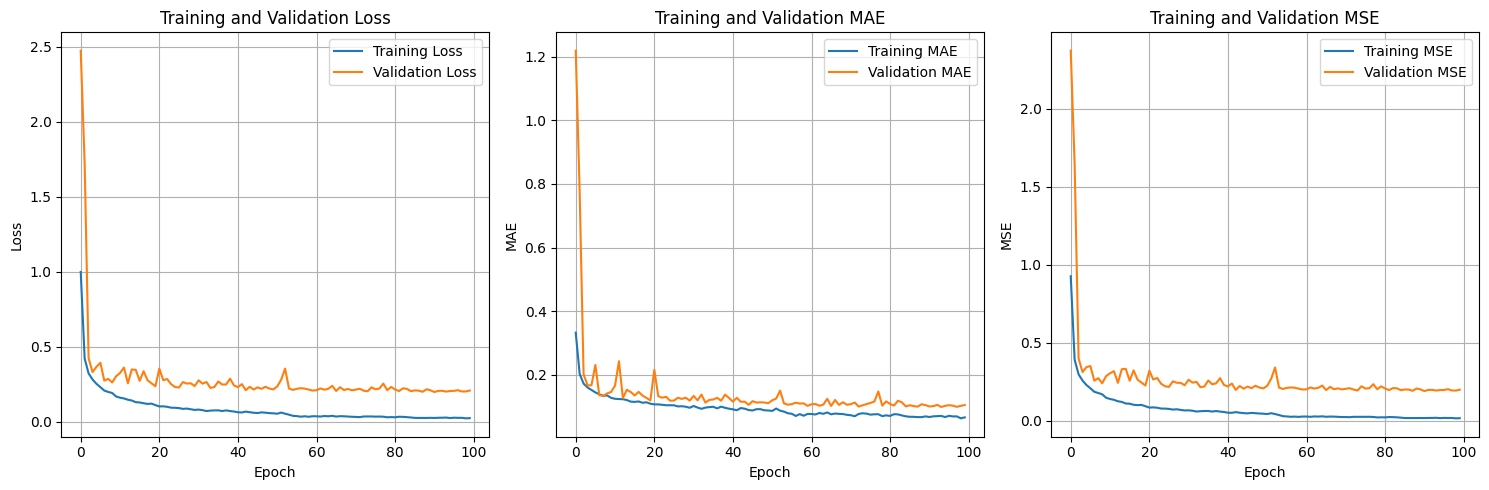

Training history saved to training_history.png

Generating Sample Predictions...

Sample predictions saved to sample_prediction_0.png, sample_prediction_1.png, sample_prediction_2.png

All Done!


In [ ]:
def train_eit_model(train_path, val_path, test_path, epochs=100, batch_size=16, resume_from=None):
    """Complete training pipeline with validation"""

    # Create data generators
    train_gen = EITDataGenerator(train_path, batch_size=batch_size, shuffle=True)
    val_gen = EITDataGenerator(
        val_path,
        batch_size=batch_size,
        shuffle=False,
        max_measurements=train_gen.max_measurements
    )
    test_gen = EITDataGenerator(
        test_path,
        batch_size=batch_size,
        shuffle=False,
        max_measurements=train_gen.max_measurements
    )

    # Build model
    input_shape = (train_gen.max_measurements * 2,)
    model = build_attention_unet(input_shape, output_shape=(128, 128, 1))

    # Load checkpoint if resuming
    if resume_from and Path(resume_from).exists():
        print(f"Loading checkpoint from {resume_from}")
        model.load_weights(resume_from)

    # Compile with gradient clipping for stability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss=eit_loss,
        metrics=['mae', 'mse']
    )

    # Print model summary
    print("\n" + "="*60)
    print("U-Net with Attention Architecture")
    print("="*60)
    model.summary()

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_attention_unet_eit.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger('training_log.csv')
    ]

    # Train
    print("\n" + "="*60)
    print("Starting Training...")
    print("="*60)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, train_gen, val_gen, test_gen


# Main execution
if __name__ == '__main__':
    print("\n" + "="*60)
    print("EIT Brain Imaging - U-Net with Attention Training")
    print("="*60)

    # Train model
    model, history, train_gen, val_gen, test_gen = train_eit_model(
        train_path='/content/drive/MyDrive/brain_eit_training/brain_eit_dataset.h5',
        val_path='/content/drive/MyDrive/brain_eit_validation/brain_eit_dataset.h5',
        test_path='/content/drive/MyDrive/brain_eit_test/brain_eit_dataset.h5',
        epochs=100,
        batch_size=16
    )

    # Save final model
    model.save('eit_attention_unet_final.keras')
    print("\n✓ Training complete! Model saved to eit_attention_unet_final.keras")

    # Evaluate on test set
    print("\n" + "="*60)
    print("Evaluating on Test Set...")
    print("="*60)

    test_results = model.evaluate(test_gen, verbose=1)
    print(f"\nTest Loss: {test_results[0]:.4f}")
    print(f"Test MAE: {test_results[1]:.4f}")
    print(f"Test MSE: {test_results[2]:.4f}")

    # Plot training history
    print("\n" + "="*60)
    print("Generating Training History Plots...")
    print("="*60)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Training and Validation MAE')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Training and Validation MSE')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Training history saved to training_history.png")

    # Generate sample predictions
    print("\n" + "="*60)
    print("Generating Sample Predictions...")
    print("="*60)

    with h5py.File('/content/drive/MyDrive/brain_eit_test/brain_eit_dataset.h5', 'r') as f:
        for i in range(min(3, len(f['difference']))):
            # Load data
            v_diff = np.array(f['difference'][i])
            gt = np.array(f['gt_difference'][i])

            # Prepare input
            features = np.concatenate([np.real(v_diff), np.imag(v_diff)])
            if len(features) < train_gen.max_measurements * 2:
                features = np.pad(features, (0, train_gen.max_measurements * 2 - len(features)))

            # Normalize
            features = (features - train_gen.X_mean) / (train_gen.X_std + 1e-8)
            features = features.reshape(1, -1)

            # Predict
            pred = model.predict(features, verbose=0)[0, :, :, 0]

            # Denormalize
            pred = pred * (train_gen.y_std + 1e-8) + train_gen.y_mean

            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            im0 = axes[0].imshow(gt, cmap='jet')
            axes[0].set_title(f'Ground Truth (Sample {i})')
            axes[0].axis('off')
            plt.colorbar(im0, ax=axes[0])

            im1 = axes[1].imshow(pred, cmap='jet')
            axes[1].set_title(f'Prediction (Sample {i})')
            axes[1].axis('off')
            plt.colorbar(im1, ax=axes[1])

            error = np.abs(gt - pred)
            im2 = axes[2].imshow(error, cmap='hot')
            axes[2].set_title(f'Absolute Error (Sample {i})')
            axes[2].axis('off')
            plt.colorbar(im2, ax=axes[2])

            plt.tight_layout()
            plt.savefig(f'sample_prediction_{i}.png', dpi=300, bbox_inches='tight')
            plt.close()

    print(f"\nSample predictions saved to sample_prediction_0.png, sample_prediction_1.png, sample_prediction_2.png")
    print("\n" + "="*60)
    print("All Done!")
    print("="*60)